In [6]:
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
from scipy.stats import binned_statistic
import scipy.integrate as integrate
import numpy as np
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from splmeter.measure.frequency import OneThirdOctave
from splmeter.processing.frequency import FrequencyWeight
from splmeter.processing.time import VoltToSPL,Resampler,TimeWeight
from splmeter.measure.time import Leq, Lmax


# import Frequency Weighting

MIC_SENSITIVITY = 0.111
REFERENCE_PRESSURE = 2.0e-5
FAST=0.125
SLOW=1





In [7]:

wav_file = 'C:/Users/Sumeet/Desktop/test.wav'

sig,fs = sf.read(wav_file)
start = 1
duration = int(sig.shape[0]/fs + 1)
if len(sig.shape) > 1:
    sig = sig[:,0]

v2s = VoltToSPL(MIC_SENSITIVITY)
fw = FrequencyWeight(fs,'A')
oto = OneThirdOctave(processing=[v2s,fw])
freq_data = oto(sig,fs)



fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.01)

# fig.add_trace(go.Scatter(x=np.arange(spl_data.shape[0]), y=spl_data,mode='lines',),
#               row=2, col=1)

fig.add_trace(go.Heatmap(
                    z=freq_data))

fig.update_layout(height=600, width=1600,
                  title_text="Acoustic plots")
fig.show()

TypeError: __init__() takes from 1 to 2 positional arguments but 3 were given

In [86]:
wav_file = 'C:/Users/Sumeet/Desktop/test.wav'

sig,fs = sf.read(wav_file)
# sig = sig[:int(fs*60)]
print(sig.shape)
resampler = Resampler(1000)
v2s = VoltToSPL(MIC_SENSITIVITY)
fw = FrequencyWeight('A')
tw = TimeWeight(integration_window=5,integration_time=1,type='Slow')
lmax = Lmax(2,1)
leq = Leq(5,1)

sig = v2s(sig)
sig = fw(sig,fs)
# sig,fs = resampler(sig,fs)

# a = tw(sig,fs)
# print(np.max(sig))
# print(sig.shape,fs)
# a = lmax(sig,fs)
# a = leq(sig,fs)


(28800000,)


In [82]:
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.01)

# fig.add_trace(go.Scatter(x=np.arange(spl_data.shape[0]), y=spl_data,mode='lines',),
#               row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(a.shape[0]), y=a,mode='lines',))

fig.update_layout(height=600, width=1600,
                  title_text="Acoustic plots")
fig.show()




In [89]:
from scipy.integrate import quad

class func():
    def __init__(self,signal,fs,timestep,timeconstant):
        self.fs = fs
        self.signal = signal
        self.lb = 0
        self.ub = signal.shape[0]
        self.timestep = timestep
        self.timeconstant = timeconstant
    def __call__(self,time):
        index = int(time*self.fs)
        if index<self.lb or index>=self.ub:
            return 0
        return self.signal[index]*np.exp(-1*(self.timestep-time)/self.timeconstant)
a = []
sig2 = np.square(sig)
timeconstant = 0.125
for i in range(0,300):    
    f = func(sig2,fs,i,timeconstant)
    integral = quad(f,0,i,limit=50)[0]
    a.append(10*np.log10(((1/(timeconstant*(REFERENCE_PRESSURE**2)))*integral)))
a = np.array(a)

c:\Users\Sumeet\Desktop\Projects\newenv\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in log10

c:\Users\Sumeet\Desktop\Projects\newenv\lib\site-packages\ipykernel_launcher.py:21: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



In [90]:
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.01)

# fig.add_trace(go.Scatter(x=np.arange(spl_data.shape[0]), y=spl_data,mode='lines',),
#               row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(a.shape[0]), y=a,mode='lines',))

fig.update_layout(height=600, width=1600,
                  title_text="Acoustic plots")
fig.show()



<AxesSubplot:>

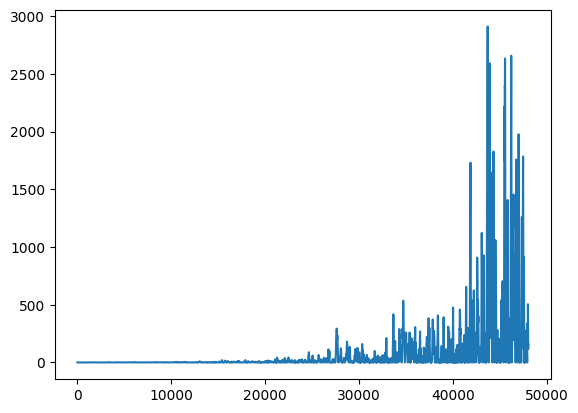

In [5]:
import seaborn as sns
a=a*10000
sns.lineplot(y=a[160],x=np.arange(0,a[160].shape[0]))


In [101]:
#!/usr/bin/env python
# coding: utf-8

# In[297]:


import io
import numpy
import os
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import pkgutil
import pandas as pd
from scipy.signal import zpk2tf
from scipy.signal import lfilter, bilinear
REFERENCE_PRESSURE = 2.0e-5
from numpy import pi, polymul
FAST=0.125
SLOW=1




def _relative_degree(z, p):
    """
    Return relative degree of transfer function from zeros and poles
    """
    degree = len(p) - len(z)
    if degree < 0:
        raise ValueError("Improper transfer function. "
                         "Must have at least as many poles as zeros.")
    else:
        return degree
def _zpkbilinear(z, p, k, fs):
    
    z = np.atleast_1d(z)
    p = np.atleast_1d(p)

    degree = _relative_degree(z, p)

    fs2 = 2.0*fs

    # Bilinear transform the poles and zeros
    z_z = (fs2 + z) / (fs2 - z)
    p_z = (fs2 + p) / (fs2 - p)

    # Any zeros that were at infinity get moved to the Nyquist frequency
    z_z = np.append(z_z, -np.ones(degree))

    # Compensate for gain change
    k_z = k * np.real(np.prod(fs2 - z) / np.prod(fs2 - p))

    return z_z, p_z, k_z


# In[274]:


import numpy as np
from numpy import pi, log10
from scipy.signal import zpk2tf, zpk2sos, freqs, sosfilt
from scipy.io import wavfile as wf

__all__ = ['ABC_weighting', 'A_weighting', 'A_weight']


def ABC_weighting(curve):
   
    if curve not in 'ABC':
        raise ValueError('Curve type not understood')

    z = [0, 0]
    k = 1

    if curve == 'A':
       
        p = [-2*pi*20.598997057568145,
         -2*pi*20.598997057568145,
         -2*pi*12194.21714799801,
         -2*pi*12194.21714799801]
        p.append(-2*pi*107.65264864304628)
        p.append(-2*pi*737.8622307362899)
        z.append(0)
        z.append(0)

    elif curve == 'C':
        p = [-0.062*pi*20.598997057568145,-0.062*pi*20.598997057568145,
         -0.062*pi*12194.21714799801,-0.062*pi*12194.21714799801]
        
        
        
        
    b, a = zpk2tf(z, p, k)
    k /= abs(freqs(b, a, [2*pi*1000])[1][0])
    
    return np.array(z), np.array(p), k
    
        



def A_weighting(fs, output='ba'):
   
    z, p, k = ABC_weighting('A')

    # Use the bilinear transformation to get the digital filter.
    z_d, p_d, k_d = _zpkbilinear(z, p, k, fs)

    if output == 'zpk':
        return z_d, p_d, k_d
    elif output in {'ba', 'tf'}:
        return zpk2tf(z_d, p_d, k_d)
    elif output == 'sos':
        return zpk2sos(z_d, p_d, k_d)
    else:
        raise ValueError("'%s' is not a valid output form." % output)
def A_weight(signal, fs,output_arr_a_eq,output_arr_a_peak):
    """
    Return the given signal after passing through a digital A-weighting filter
    signal : array_like
        Input signal, with time as dimension
    fs : float
        Sampling frequency
    """
    
    sos = A_weighting(fs,output='sos')
    y=sosfilt(sos, signal)
    rms_y=(np.sqrt(np.mean(np.absolute(y)**2)))
    output_arr_a_eq.append(20*np.log10(rms_y//REFERENCE_PRESSURE))
    output_arr_a_peak.append(20*np.log10(np.amax(np.abs(y))//REFERENCE_PRESSURE))
    

        
def C_weighting(fs, output='ba'):
    z, p, k = ABC_weighting('C')

    # Use the bilinear transformation to get the digital filter.
    z_d, p_d, k_d = _zpkbilinear(z, p, k, fs)

    if output == 'zpk':
        return z_d, p_d, k_d
    
    elif output in {'ba', 'tf'}:
        return zpk2tf(z_d, p_d, k_d)
    elif output == 'sos':
        return zpk2sos(z_d, p_d, k_d)
    else:
        raise ValueError("'%s' is not a valid output form." % output)
def C_weight(sig,fs,output_arr_c_eq,output_arr_c_peak):

    sos=C_weighting(fs,output='sos')
    y=sosfilt(sos,sig)
    rms_y=(np.sqrt(np.mean(np.absolute(y)**2)))
    output_arr_c_eq.append(20*np.log10(rms_y//REFERENCE_PRESSURE))
    output_arr_c_peak.append(20*np.log10(np.amax(np.abs(y))//REFERENCE_PRESSURE))
    


def integrate(data, sample_frequency, integration_time):
    integration_time = np.asarray(integration_time)
    sample_frequency = np.asarray(sample_frequency)
    samples = data.shape[-1]
    b, a = zpk2tf([1.0], [1.0, integration_time], [1.0])
    b, a = bilinear(b, a, fs=sample_frequency)
    n = np.floor(integration_time * sample_frequency).astype(int)
    data = data[..., 0:n * (samples // n)]
    newshape = list(data.shape[0:-1])
    newshape.extend([-1, n])
    data = data.reshape(newshape)

    data = data.reshape((-1, n)) # Divide in chunks over which to perform the integration.
    return lfilter(
        b, a,
 
        data)[..., n - 1] / integration_time   # Perform the integration. Select the final value of the integration.
    


# In[295]:



def time_weighted_sound_level(pressure, sample_frequency):
    """Time-weighted sound pressure level.

    :param pressure: Dynamic pressure.
    :param sample_frequency: Sample frequency.
    :param integration_time: Integration time.
    :param reference_pressure: Reference pressure.
    """

    levels_fast = 10.0 * np.log10(integrate(pressure**2.0, sample_frequency, FAST) / REFERENCE_PRESSURE**2.0)
    levels_slow = 10.0 * np.log10(integrate(pressure**2.0, sample_frequency, SLOW) / REFERENCE_PRESSURE**2.0)
    times_fast= np.arange(levels_fast.shape[-1]) * FAST
    times_slow= np.arange(levels_slow.shape[-1]) * SLOW
    # plt.plot(times_fast, levels_fast,label="A-Fast")
    # plt.legend()
    # plt.yticks(np.arange(0, 100, 10.0))
    # plt.plot(times_slow,levels_slow,label="A-slow")
    # plt.legend()
    # plt.yticks(np.arange(0, 100, 10.0))
    # plt.title(" Fast and Slow Wave Graph (A)")
    # label_y=plt.ylabel("Sound Pressure Level (dB)")
    # label_y.set_color("green")
    # label_x=plt.xlabel("Time (s)")
    # label_x.set_color("green")
    # plt.show()
    
    return(levels_fast,times_fast,levels_slow,times_slow)


# In[296]:


sig,fs = sf.read('C:/Users/Sumeet/Desktop/test.wav')
sig = sig/0.111
sos = C_weighting(fs,output='sos')
y_a=sosfilt(sos, sig)
# for i in range(0,((len(sig)//fs)//60)):
#     lf,tf,ls,ts = time_weighted_sound_level(y_a[i*fs*60:((i+1)*fs*60)+1],fs)
#     break
lf,tf,ls,ts = time_weighted_sound_level(sig,fs)
a = lf
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.01)

# fig.add_trace(go.Scatter(x=np.arange(spl_data.shape[0]), y=spl_data,mode='lines',),
#               row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(a.shape[0]), y=a,mode='lines',))

fig.update_layout(height=600, width=1600,
                  title_text="Acoustic plots")
fig.show()


In [114]:
from scipy.signal import zpk2tf
from scipy.signal import lfilter
z = [0]
p = [-1/0.125]
k = 1
# b,a = zpk2tf(z, p, k)
b,a = zpk2tf([1.0], [1.0, 0.125], [1.0])
# b, a = bilinear(b, a, fs=2)
# x=[1,2,3,4,5,6,6,6,6,7]
# lfilter(b, a, x, axis=-1, zi=None)



In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from splmeter.signal import SoundPressure,SoundLevel
from splmeter.measure.frequency import OneThirdOctave 
from splmeter.processing.frequency import FrequencyWeight
from splmeter.processing.time import VoltToSPL, Resampler, TimeWeight

fs = 48000
frequencies = [
                16,
                20,
                25,
                31.5,
                40,
                50,
                63,
                80,
                100,
                125,
                160,
                200,
                250,
                315,
                400,
                500,
                630,
                800,
                1000,
                1250,
                1600,
                2000,
                2500,
                3150,
                4000,
                5000,
                6300,
                8000,
                10000,
                12500,
                16000,
                20000,
                ]





sig_arr = None
for freq in frequencies:
    if sig_arr is None:
        sig_arr = np.sin((2*np.pi*freq)*(np.arange(0,fs)/48000))
        continue
    sig_arr += np.sin((2*np.pi*freq)*(np.arange(0,fs)/48000))


# sig_arr = np.zeros(48000) 

sig = SoundPressure().from_array(0.5*sig_arr,fs)

oto = OneThirdOctave()
# fw_a = FrequencyWeight('A')
fw_c = FrequencyWeight('A')

# v2s = VoltToSPL(0.111)
# # rsmplr = Resampler(800)
# tw = TimeWeight(2,1,'Slow')

# sig = v2s(sig)
# sig_a = fw_a(sig)
sig_c = fw_c(sig)
sig_oa = oto(sig_c)
sig_o = oto(sig)

print(sig_oa.amplitude - sig_o.amplitude)
# sig = rsmplr(sig)
# sig = tw(sig)
# sig = fw(sig)


# print(sig.type)
sig_o.print_ops()

a = sig_oa.amplitude

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.01)

if len(a.shape) > 1:
    fig.add_trace(go.Heatmap(
                    z=a))
else:
    fig.add_trace(go.Scatter(x=np.arange(a.shape[0]), y=a,mode='lines',))

fig.update_layout(height=600, width=1600,
                  title_text="Acoustic plots")
fig.show()


[[-5.60966716e+01]
 [-5.03554132e+01]
 [-4.47874648e+01]
 [-3.94529309e+01]
 [-3.49140598e+01]
 [-3.05449539e+01]
 [-2.64427396e+01]
 [-2.25693302e+01]
 [-1.92860118e+01]
 [-1.63007654e+01]
 [-1.33316111e+01]
 [-1.09167557e+01]
 [-8.73013700e+00]
 [-6.68725973e+00]
 [-4.80753948e+00]
 [-3.27389468e+00]
 [-1.92799381e+00]
 [-8.08706124e-01]
 [-9.82774341e-03]
 [ 5.69493926e-01]
 [ 9.88706796e-01]
 [ 1.19781363e+00]
 [ 1.26502850e+00]
 [ 1.18745994e+00]
 [ 9.26453553e-01]
 [ 4.63605501e-01]
 [-3.37636046e-01]
 [-1.68868224e+00]
 [-3.70484241e+00]
 [-6.92132559e+00]
 [-1.31366859e+01]
 [-2.51846895e+01]]
Origin {'Signal Type': 'Pressure(Pa)/Volts(V)', 'Signal Length(s)': 1.0, 'Sample Frequency': 48000}
Frequency Weighting {'Weighting Type': 'A'}
One-Third Octave {'Reference Pressure': 2e-05}
One-Third Octave {'Reference Pressure': 2e-05}
End {'Signal Type': 'Level(dB)', 'Signal Length(s)': 1.0, 'Sample Frequency': 1}


In [24]:
import csv


def get_tolerance_dict_from_csv(filename):
    tolerance_dict  ={}
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        
        for i, row in enumerate(csv_reader):
            print(row[1].replace("−", "-"))
            if i == 0:
                continue
            tolerance_dict[float(row[0])] = {'A':float(row[1]),
                                        'C':float(row[2]),
                                        'class1':[float(row[4]),float(row[3])],
                                        'class2':[float(row[4]),float(row[3])]

                                        }
    
    if len(tolerance_dict)<=0:
        raise Exception('Tolerance file could not be processed.')            
    return tolerance_dict

filename = 'C:/Users/Sumeet/Desktop/Projects/splmeter/src/test/data/tol.csv'
get_tolerance_dict_from_csv(filename)
    #     if line_count == 0:
    #         print(f'Column names are {", ".join(row)}')
    #         line_count += 1
    #     else:
    #         print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
    #         line_count += 1
    # print(f'Processed {line_count} lines.')

A
-56.7
-50.5


{16.0: {'A': -56.7,
  'C': -8.5,
  'class1': [-99999.0, 3.5],
  'class2': [-99999.0, 3.5]},
 20.0: {'A': -50.5, 'C': -6.2, 'class1': [-4.5, 2.5], 'class2': [-4.5, 2.5]}}

In [27]:
from splmeter.test.processing.test_frequency import Test_frequency_weighting
from splmeter.measure.frequency import OneThirdOctaveBinCentral


t = Test_frequency_weighting()
t.test_A_weighting()

ImportError: cannot import name 'OneThirdOctaveBinCentral' from 'splmeter.measure.frequency' (c:\Users\Sumeet\Desktop\Projects\splmeter\src\splmeter\measure\frequency.py)